In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')
from kneed import KneeLocator

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_supp_resist, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

In [2]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

In [3]:
from dateutil.relativedelta import relativedelta
from math import ceil, floor

def test_option_trading(stock_name,
                        start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                        end=datetime.today().strftime('%Y-%m-%d')
                       ):
    df = yf.download(stock_name.upper(), start=start, end=end)
                     
    df = df.reset_index()
    
    print(datetime.today().strftime('%Y-%m-%d'))

    low_clusters = get_optimum_clusters(df[(df['Low']!=df['Open'])&(df['Low']!=df['Close'])][['Date',"Low"]].set_index('Date'))
    # low_clusters = get_optimum_clusters(df[['Date',"Low"]].set_index('Date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df[(df['High']!=df['Open'])&(df['High']!=df['Close'])][['Date',"High"]].set_index('Date'))
    # high_clusters = get_optimum_clusters(df[['Date',"High"]].set_index('Date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    close = df.iloc[-1]['Close']
    try: 
        support = max([e[0] for e in low_centers if e < close])
    except:
        print('Break all support; record min stock price')
        support = df['Low'].min()
    try:
        resistance = min([e[0] for e in high_centers if e > close])
    except:
        print('Break all resistance; record max stock price')
        resistance = df['High'].max()

    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    
    # Calculate upper and lower bands
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    close = df.iloc[-1]['Close']
    print('* previous stock price closing', round(close,2), '~ up', ceil(resistance*100)/100.0, ', down', floor(support*100)/100)
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
    print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])
        
    print(low_centers)
    print(high_centers)

    ax = plot_candlestick(df, figsize=(32,8))
    ax.set_title(stock_name)
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')

    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')
    # df['5_MA'] = df['Close'].rolling(window=5).mean()
    # df['9_MA'] = df['Close'].rolling(window=9).mean()
    # df['20_MA'] = df['Close'].rolling(window=20).mean()
    # df['50_MA'] = df['Close'].rolling(window=50).mean()

    # ax.plot(df['Date'], df['Close'], color='black')
    # ax.plot(df['Date'], df['5_MA'], ls='--')

    # ax.plot(df['Date'], df['9_MA'], ls='--')
    # ax.plot(df['Date'], df['20_MA'], ls='--')
    # ax.plot(df['Date'], df['50_MA'], ls='--')
    ax.plot(df['Date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df['Date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
    ax.plot(df['Date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
    ax.fill_between(df['Date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands


## Test effectiveness of support and resistance in option trading

### Strategy 1:
* Touch support: long call
* Touch resistance: long put

#### Fail

### Strategy 2:

* Touch support
    * reflect: long call
    * break: long put
* Touch resistance:
    * reflect: long put
    * break: long call
    
#### Key question: how to confirm break / reflect?

* Base assumption: assume the support and resistance to hold, unless strong conflict signal observed.
* Assumption1.1: when going down, a short red line / long green line confirm reflect; long red line confirm break
* Assumption1.2: when going up, a short green line / long red line confirm reflect; long green line confirm break
* ~~Read from 1-min Candlestick~~ -- not applicable
* Check if trend is align with QQQ/SPY


#### Stop revenue needed; for conservative, start with 20%.

#### Precision of level should be relative to the stock price.

#### Hard to validate/'

### Strategy 3: 

* Touch support / resistance: check with the daily price range, 95% confidence

QQQ & TQQQ

[*********************100%%**********************]  1 of 1 completed
2024-04-12
Break all resistance; record max stock price
* previous stock price closing 445.37 ~ up 449.34 , down 437.59
Latest 20 Day MA: 441.62950286865237
Latest Lower Bollinger Band: 434.45694368911256
Latest Higher Bollinger Band: 448.80206204819217
[[317.17874908]
 [331.93249893]
 [347.65266724]
 [357.08562469]
 [365.96600037]
 [374.84413621]
 [386.91454523]
 [404.19608605]
 [423.29789493]
 [437.59486898]]
[[321.59960205]
 [336.72285679]
 [351.27333238]
 [359.24956745]
 [368.01785569]
 [376.26970628]
 [388.45642962]
 [407.68719971]
 [428.72761754]
 [442.92540679]]


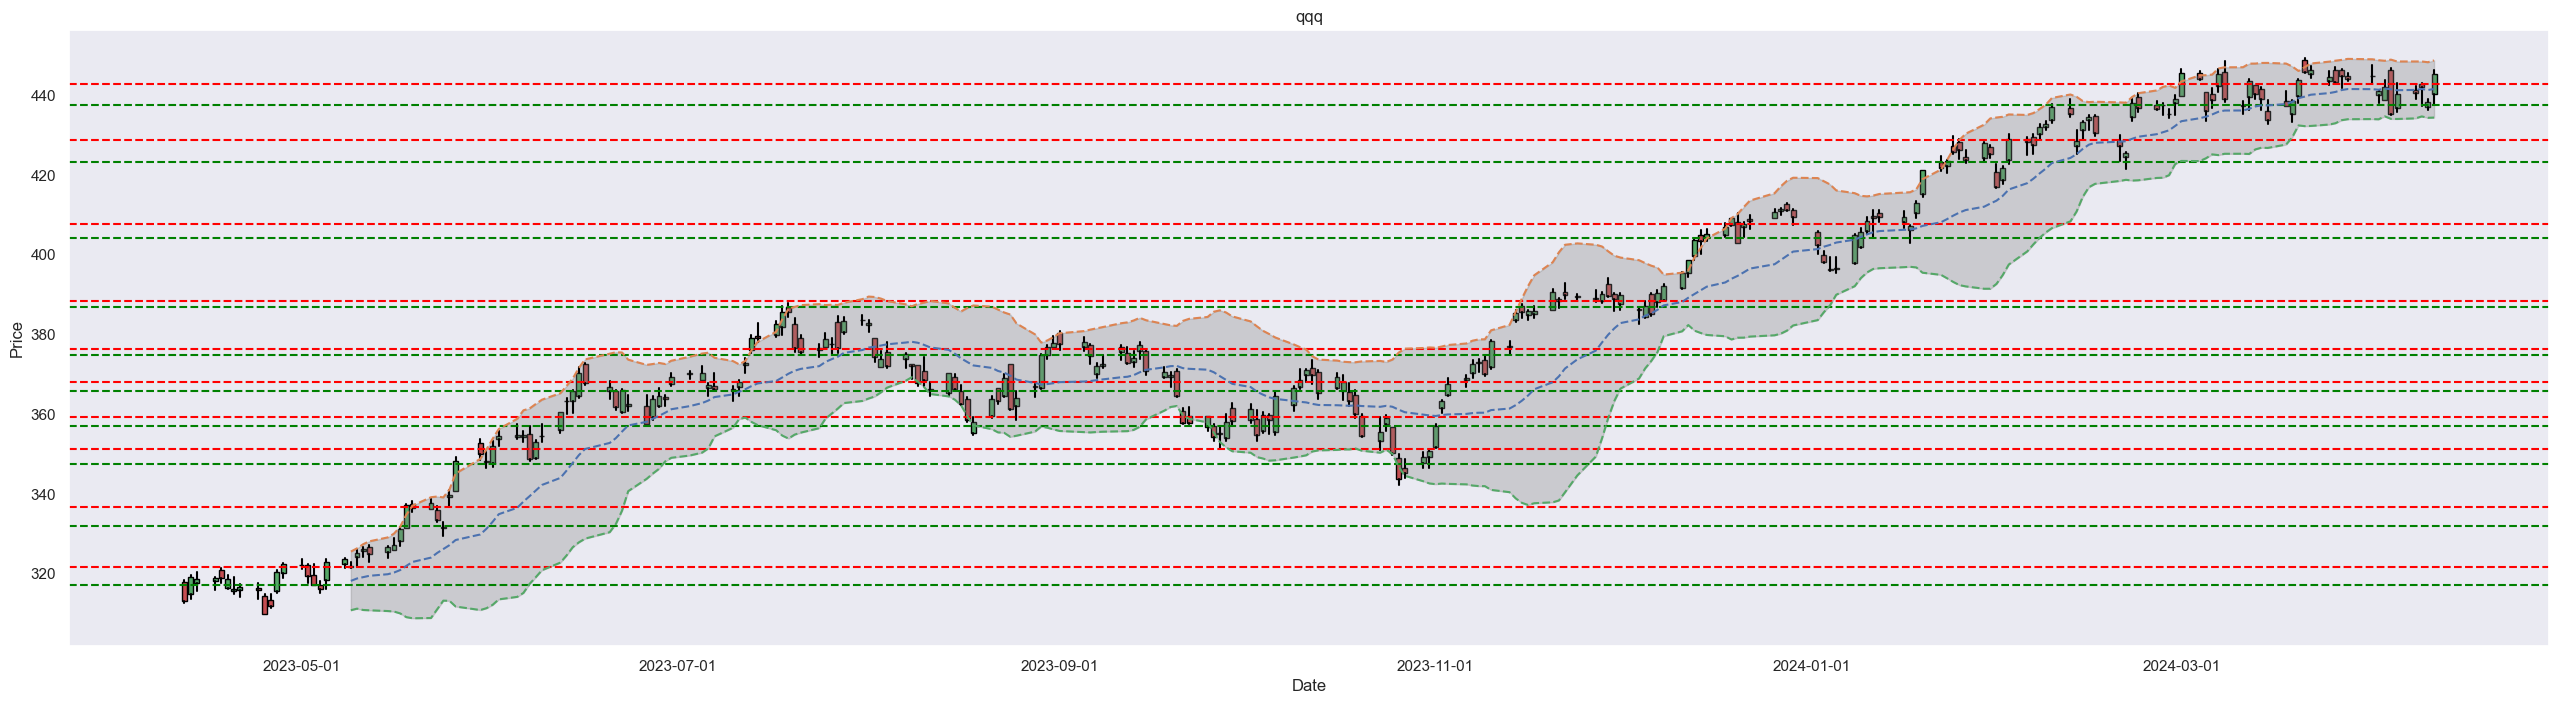

In [4]:
test_option_trading('qqq')

[*********************100%%**********************]  1 of 1 completed
2024-04-12
* previous stock price closing 61.7 ~ up 62.9 , down 61.25
Latest 20 Day MA: 60.61350021362305
Latest Lower Bollinger Band: 57.72842144437271
Latest Higher Bollinger Band: 63.49857898287339
[[27.11730766]
 [31.63846207]
 [35.25468755]
 [38.42045446]
 [41.56257139]
 [44.44772738]
 [49.11499996]
 [54.62187457]
 [58.51935516]
 [61.25545467]]
[[28.04960007]
 [32.09454536]
 [36.42032242]
 [39.61809494]
 [42.40705883]
 [45.41620675]
 [50.55952381]
 [56.54937434]
 [60.24576862]
 [62.89266663]]


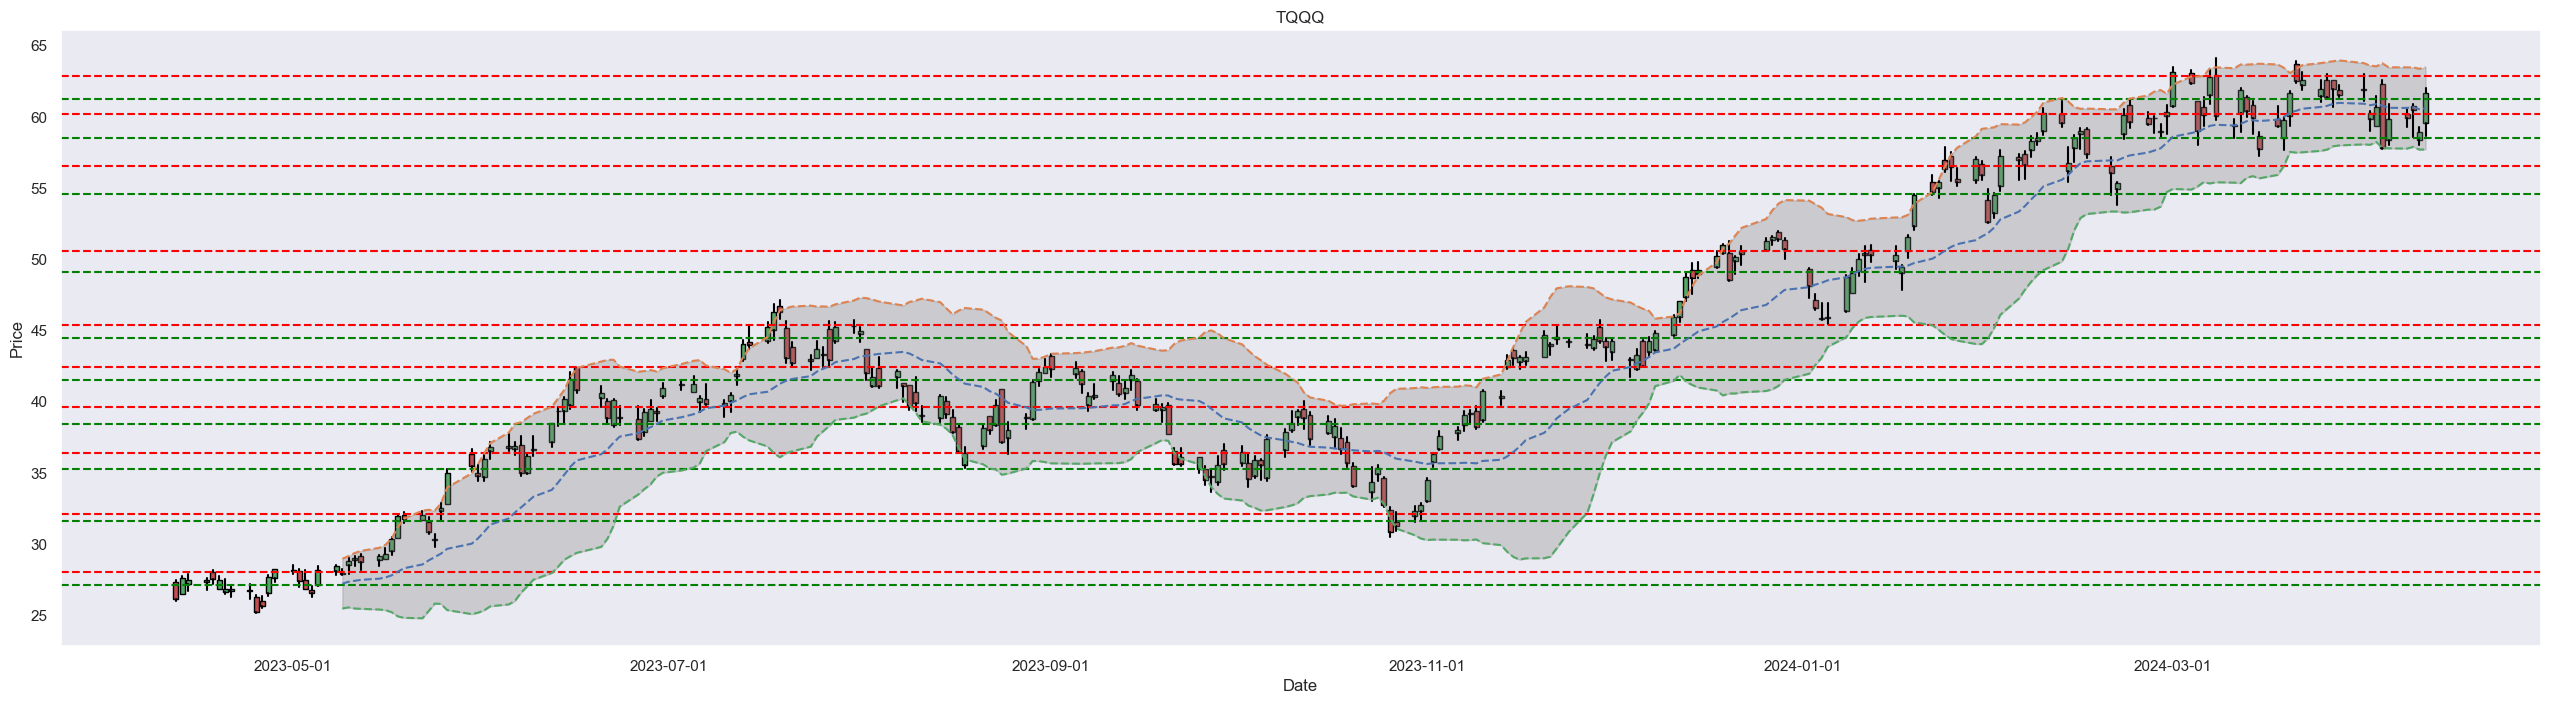

In [5]:
test_option_trading('TQQQ')

SPY & UPRO

[*********************100%%**********************]  1 of 1 completed
2024-04-12
* previous stock price closing 518.0 ~ up 520.89 , down 508.84
Latest 20 Day MA: 518.2064987182617
Latest Lower Bollinger Band: 510.8225352634528
Latest Higher Bollinger Band: 525.5904621730707
[[410.39194404]
 [422.23538325]
 [433.38567703]
 [442.83624935]
 [452.51281817]
 [470.99920166]
 [485.06777954]
 [494.95538095]
 [508.84095401]
 [518.1499939 ]]
[[414.83947352]
 [427.73166784]
 [437.35628401]
 [447.56625137]
 [456.90580602]
 [474.65583547]
 [488.05999756]
 [498.78076876]
 [511.78124809]
 [520.88104891]]


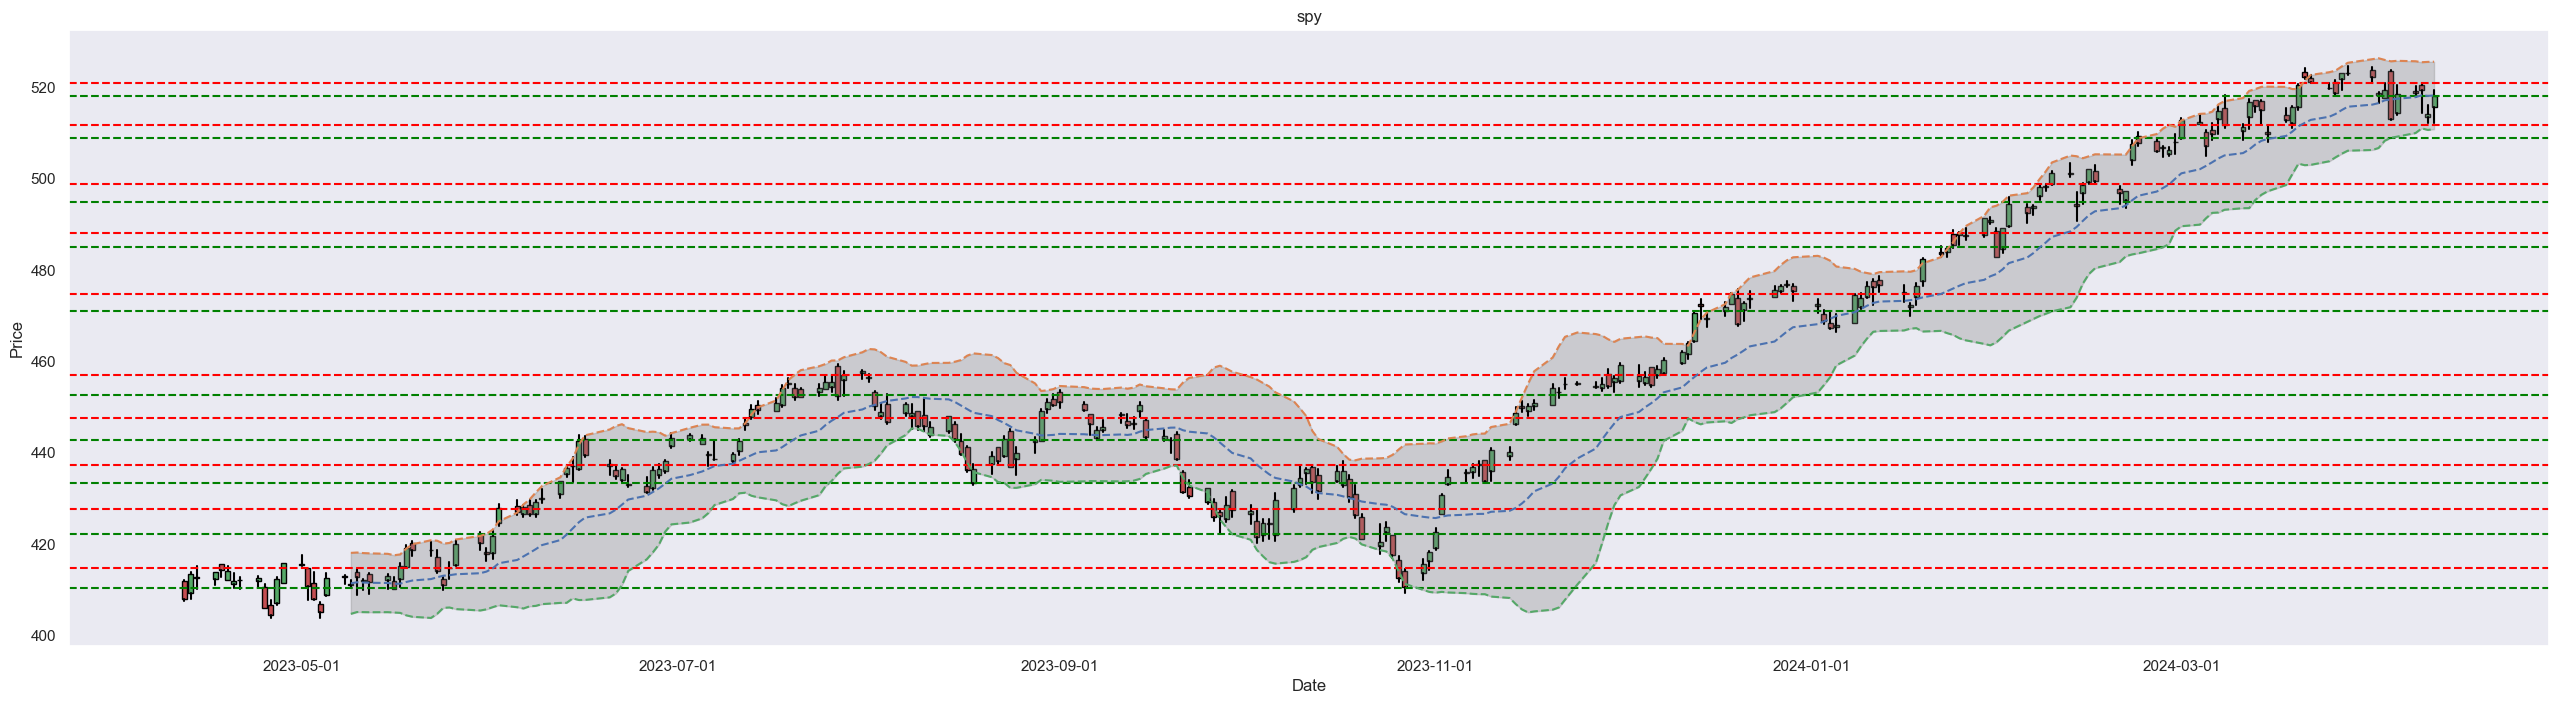

In [6]:
test_option_trading('spy')

[*********************100%%**********************]  1 of 1 completed
2024-04-12
* previous stock price closing 68.1 ~ up 69.4 , down 65.9
Latest 20 Day MA: 68.60049896240234
Latest Lower Bollinger Band: 65.70171772209724
Latest Higher Bollinger Band: 71.49928020270744
[[38.27638293]
 [41.8530307 ]
 [45.0721209 ]
 [47.54609764]
 [50.36133347]
 [53.49272693]
 [58.42250013]
 [62.78583336]
 [65.90058764]
 [69.0345452 ]]
[[39.38590917]
 [42.98029428]
 [46.10666669]
 [48.33099995]
 [50.76842117]
 [54.46416696]
 [58.58199997]
 [61.97615403]
 [66.00153762]
 [69.39227295]]


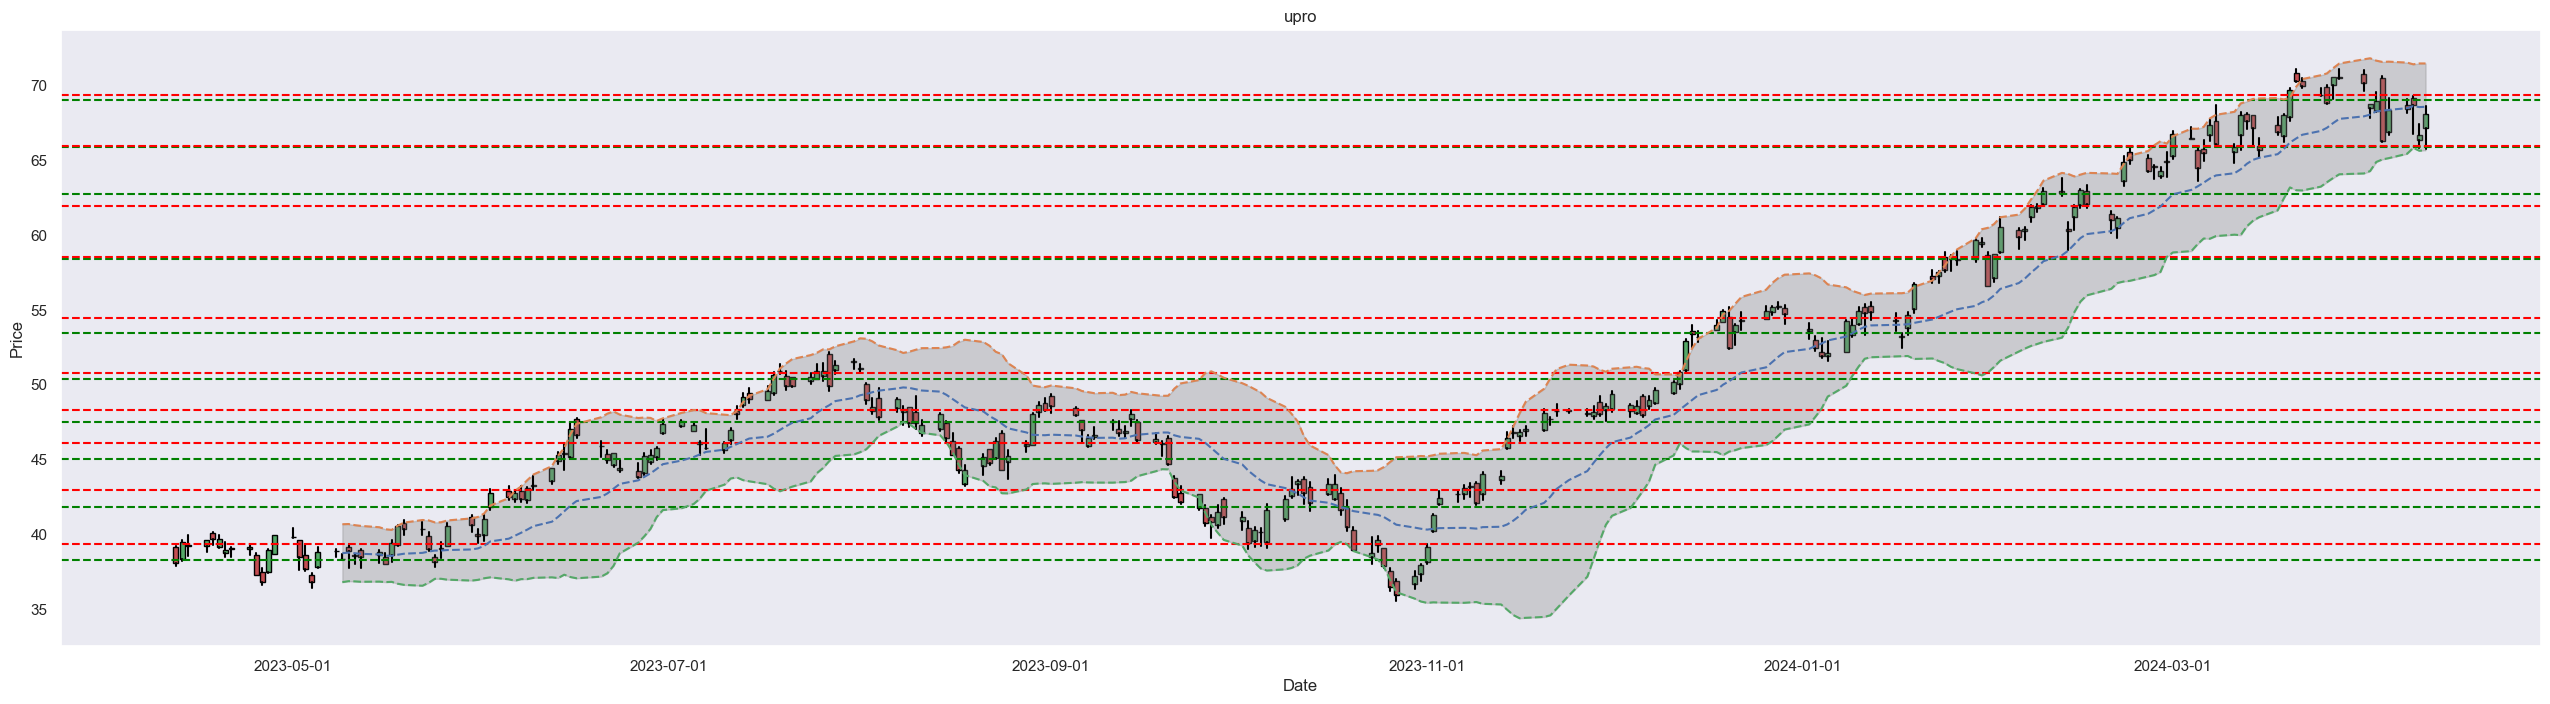

In [7]:
test_option_trading('upro')

SOXX & SOXL

[*********************100%%**********************]  1 of 1 completed
2024-04-12
* previous stock price closing 225.47 ~ up 227.48 , down 222.38
Latest 20 Day MA: 222.8239990234375
Latest Lower Bollinger Band: 216.52381700007098
Latest Higher Bollinger Band: 229.124181046804
[[137.08846107]
 [148.21166611]
 [157.19894811]
 [163.11774878]
 [170.02057979]
 [181.33333435]
 [190.88000107]
 [199.82577718]
 [210.67307692]
 [222.38615241]]
[[139.8491029 ]
 [150.28513043]
 [159.11533356]
 [165.28634048]
 [171.75579701]
 [179.12142944]
 [190.10650253]
 [202.92395782]
 [213.71435899]
 [227.47928456]]


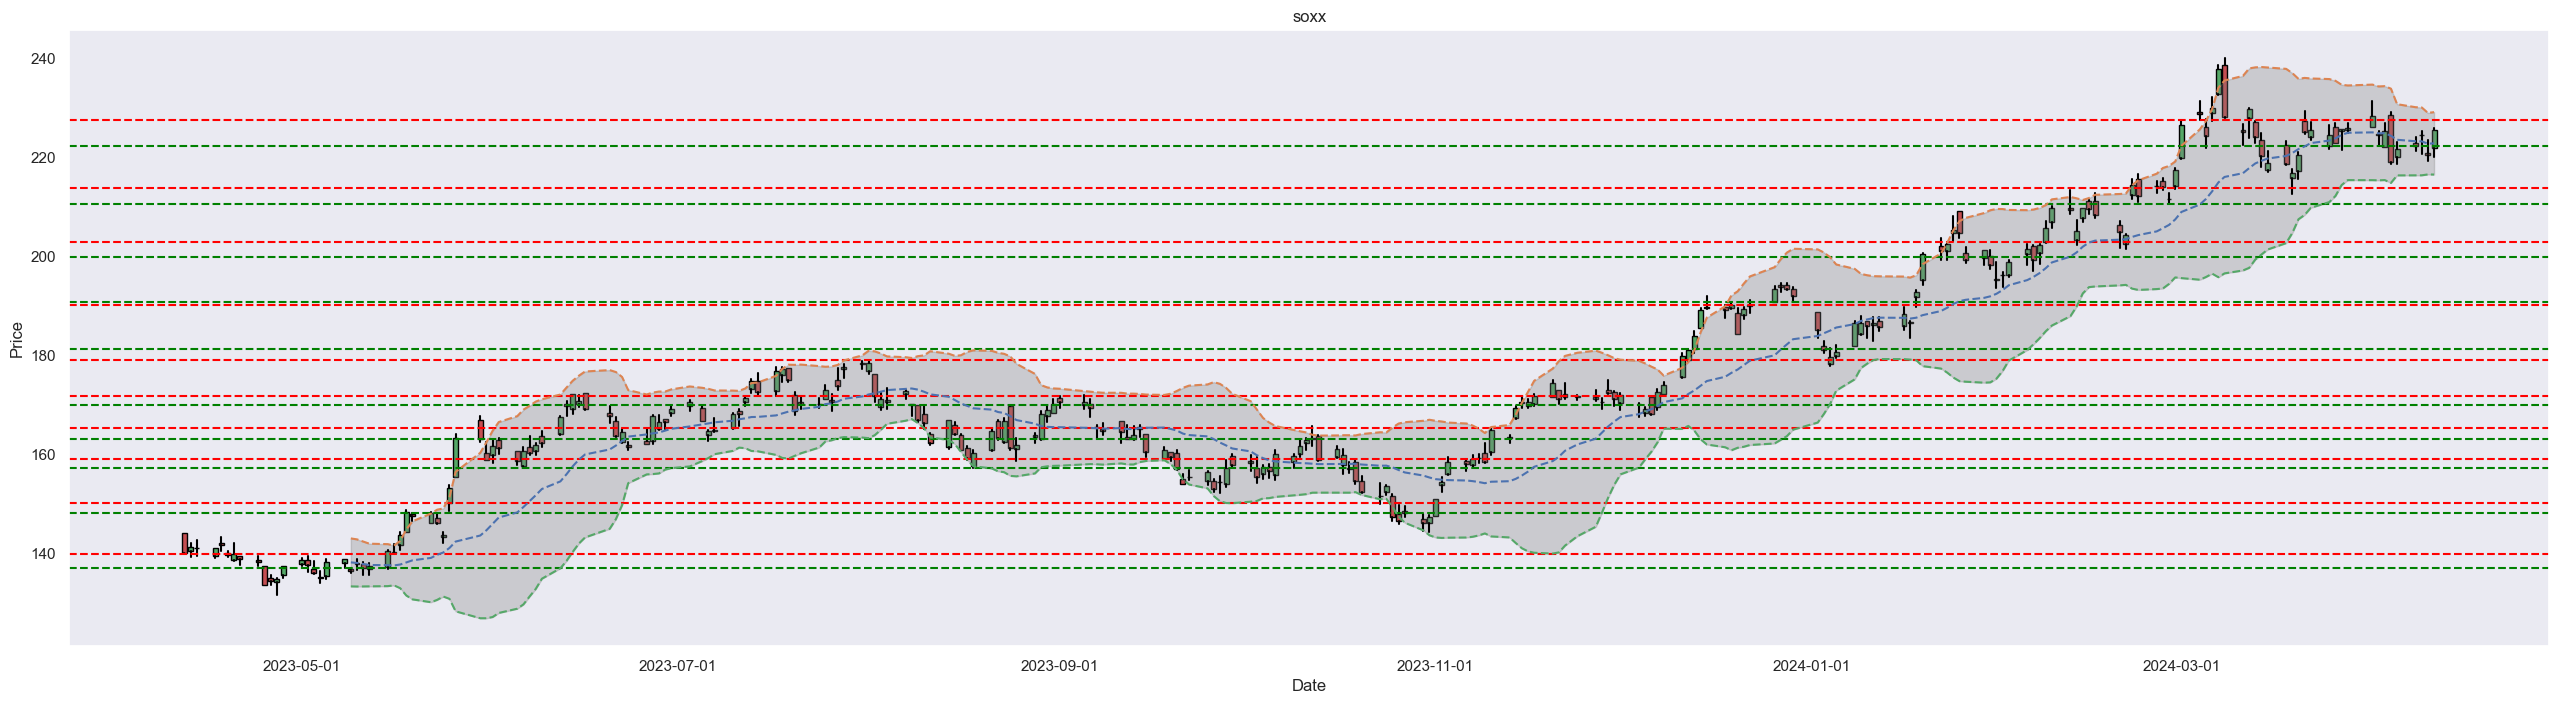

In [8]:
test_option_trading("soxx")

[*********************100%%**********************]  1 of 1 completed
2024-04-12
* previous stock price closing 45.8 ~ up 47.18 , down 44.73
Latest 20 Day MA: 44.73249988555908
Latest Lower Bollinger Band: 41.12541947958687
Latest Higher Bollinger Band: 48.33958029153129
[[14.31941178]
 [17.80648649]
 [21.0342222 ]
 [23.5107143 ]
 [26.72960007]
 [30.92733307]
 [34.68357113]
 [40.27333344]
 [44.73999988]
 [49.65499973]]
[[15.26375002]
 [19.12175002]
 [22.68086952]
 [25.26200013]
 [28.58947362]
 [31.87333298]
 [36.12923079]
 [41.35624981]
 [47.1786362 ]
 [54.07750034]]


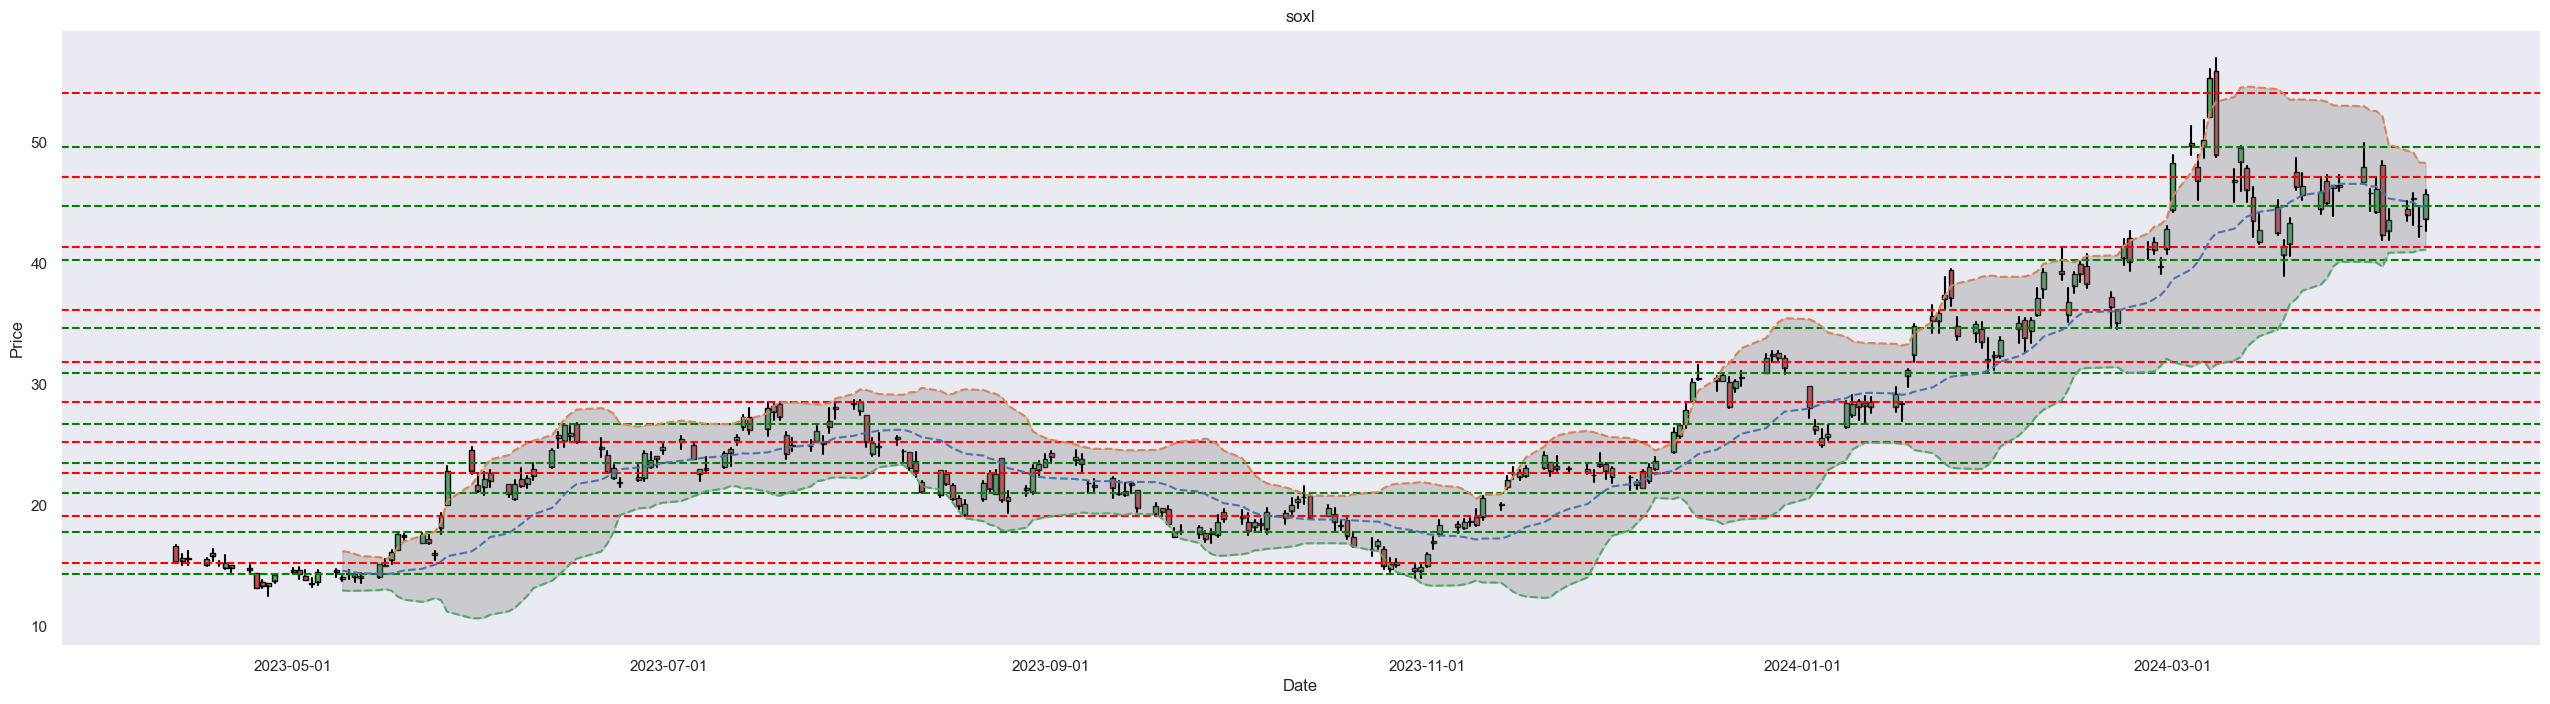

In [9]:
test_option_trading("soxl")

NVDA & NVDL

[*********************100%%**********************]  1 of 1 completed
2024-04-12
* previous stock price closing 906.16 ~ up 940.57 , down 899.48
Latest 20 Day MA: 895.3664978027343
Latest Lower Bollinger Band: 844.9123881787203
Latest Higher Bollinger Band: 945.8206074267483
[[279.24644913]
 [405.95245073]
 [444.92245323]
 [479.22113731]
 [545.05125427]
 [608.22299805]
 [693.71916707]
 [774.80999756]
 [856.32646628]
 [899.4827215 ]]
[[287.26935307]
 [422.95152567]
 [460.88061087]
 [490.84630419]
 [553.02750397]
 [622.8490878 ]
 [719.97332764]
 [803.31143624]
 [894.69444105]
 [940.56399536]]


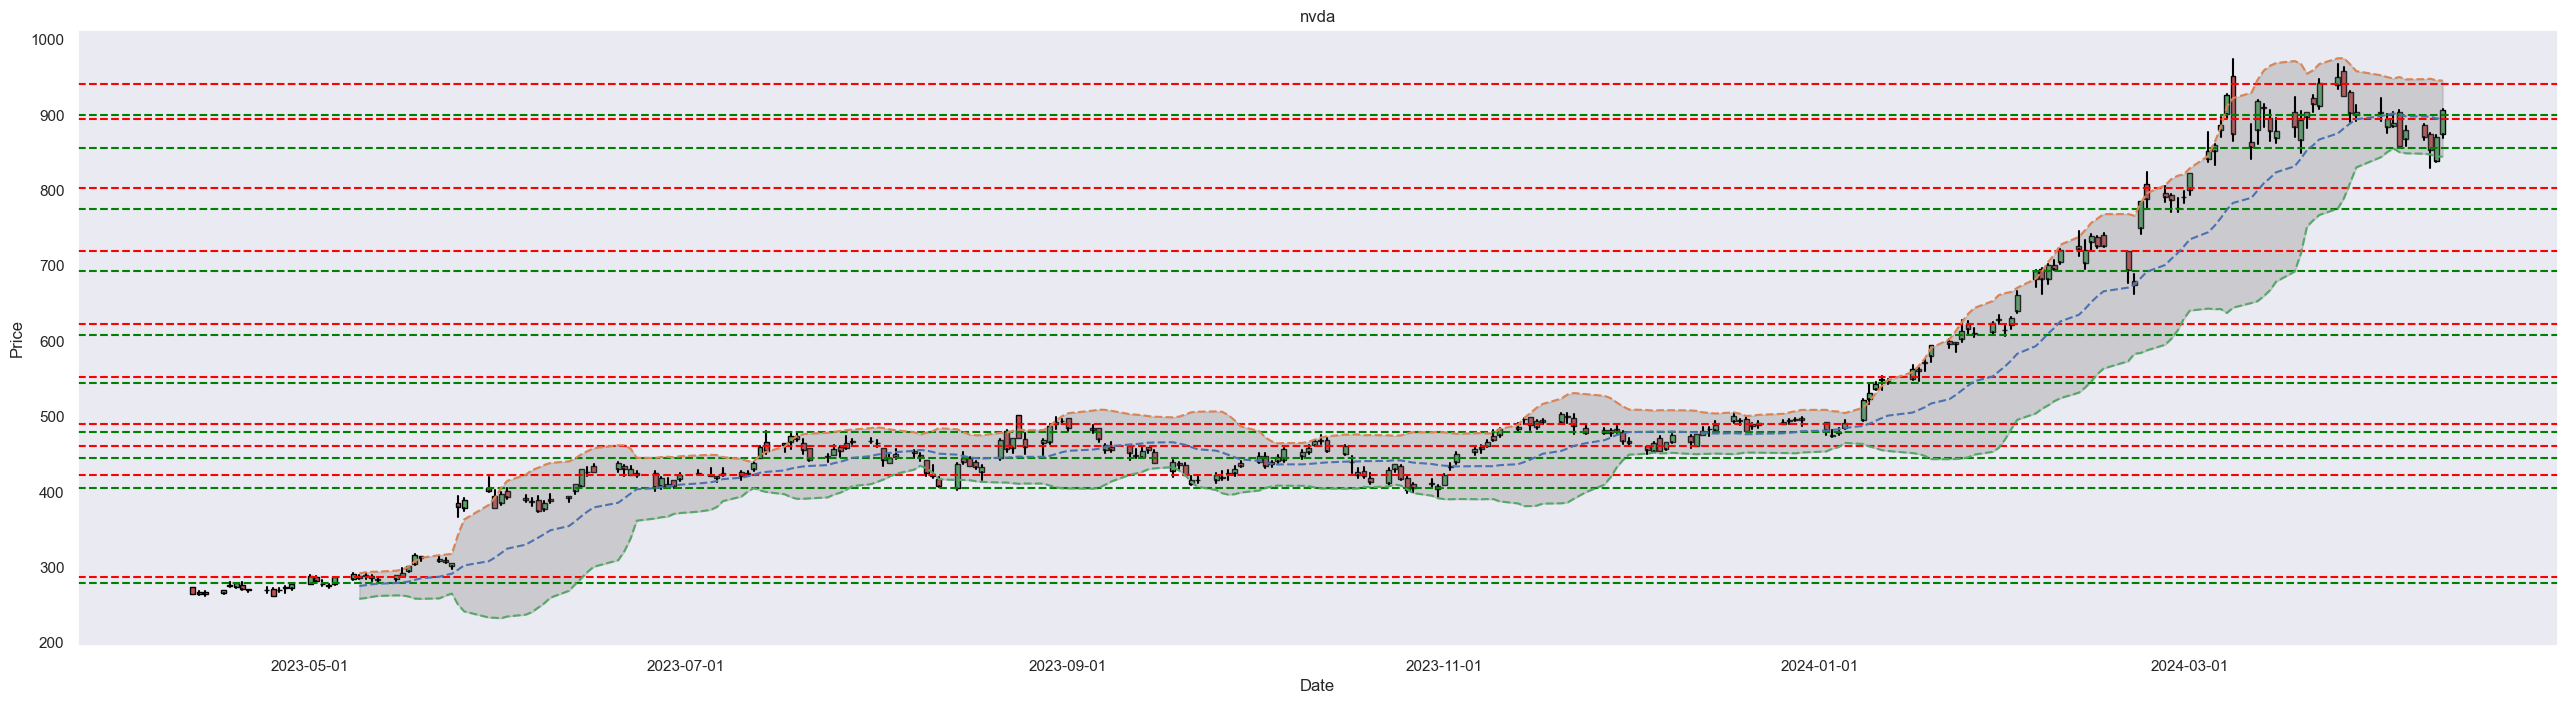

In [10]:
test_option_trading('nvda')

[*********************100%%**********************]  1 of 1 completed
2024-04-12
* previous stock price closing 41.44 ~ up 42.21 , down 41.3
Latest 20 Day MA: 40.921500015258786
Latest Lower Bollinger Band: 36.092978276513755
Latest Higher Bollinger Band: 45.75002175400382
[[ 7.84457478]
 [12.82145924]
 [14.52390299]
 [16.17698553]
 [20.14377299]
 [24.88428552]
 [28.09886042]
 [32.39659555]
 [37.74666646]
 [41.30197175]]
[[ 8.19912811]
 [13.36396457]
 [14.8694221 ]
 [16.69396064]
 [21.47888904]
 [28.11618074]
 [33.87278639]
 [39.33166695]
 [42.20993322]
 [46.62219493]]


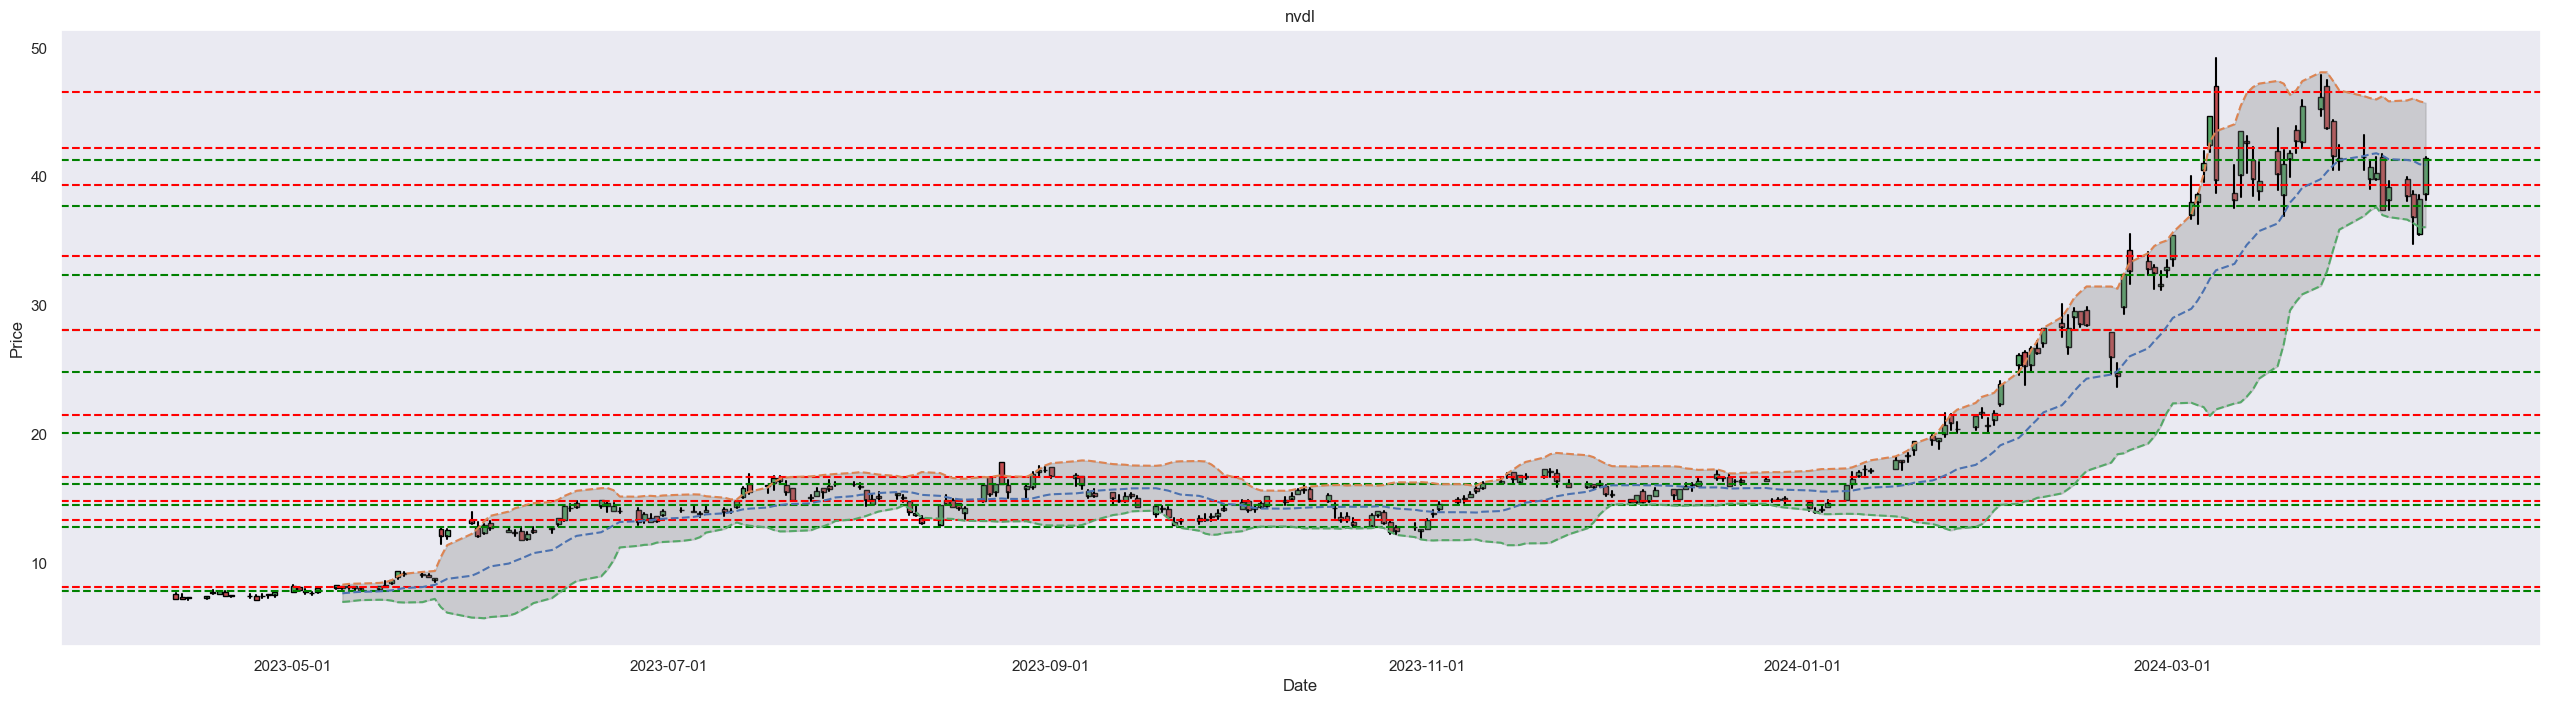

In [11]:
test_option_trading("nvdl")

Gld & UGL

[*********************100%%**********************]  1 of 1 completed
2024-04-12
Break all resistance; record max stock price
* previous stock price closing 219.8 ~ up 219.84 , down 214.76
Latest 20 Day MA: 207.17550201416014
Latest Lower Bollinger Band: 193.04260936604976
Latest Higher Bollinger Band: 221.30839466227053
[[170.01333449]
 [175.52882385]
 [178.18149986]
 [181.11581456]
 [183.82348881]
 [187.2321167 ]
 [189.85666826]
 [199.83117766]
 [208.99250031]
 [214.76999817]]
[[169.83600159]
 [174.7563643 ]
 [178.79255352]
 [182.20209166]
 [185.03923074]
 [188.44459108]
 [191.97875023]
 [201.6238895 ]
 [211.50999832]
 [217.80599976]]


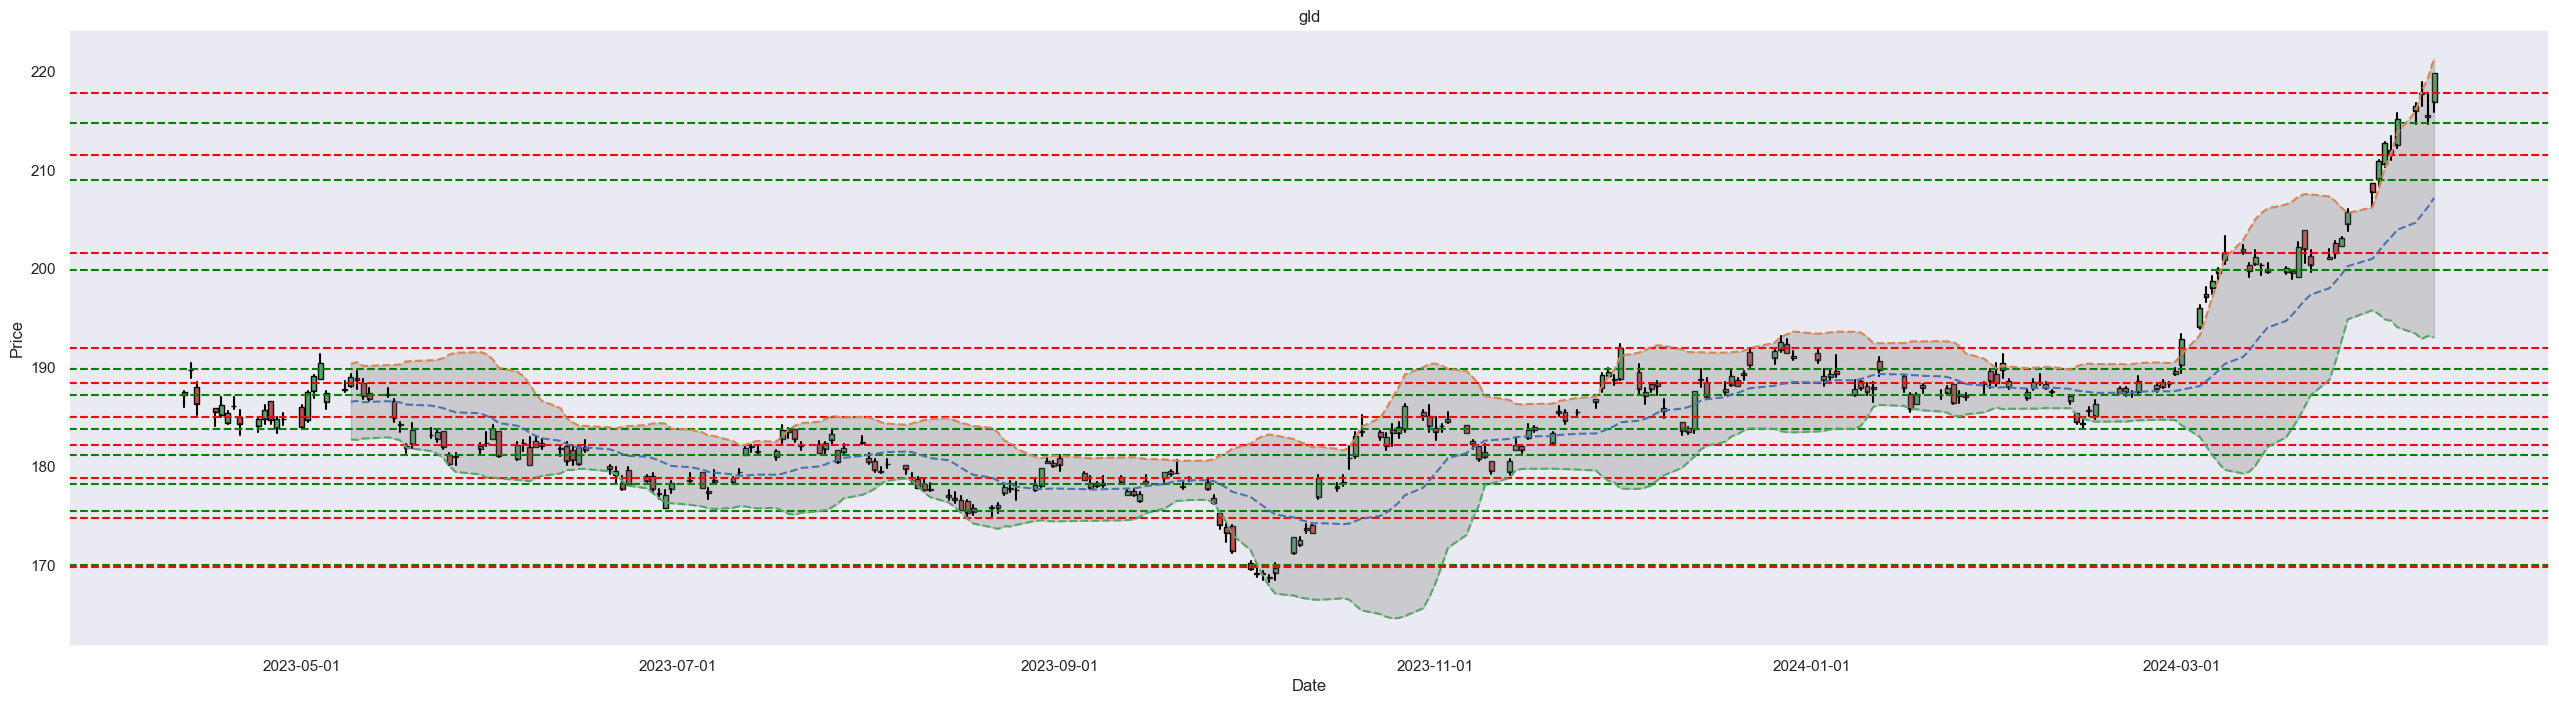

In [12]:
test_option_trading('gld')

[*********************100%%**********************]  1 of 1 completed
2024-04-12
Break all resistance; record max stock price
* previous stock price closing 82.14 ~ up 82.25 , down 79.03
Latest 20 Day MA: 73.38750038146972
Latest Lower Bollinger Band: 63.673268972851304
Latest Higher Bollinger Band: 83.10173179008814
[[52.23416646]
 [56.60057155]
 [58.42275   ]
 [60.28838705]
 [61.71692286]
 [64.00370379]
 [67.47076944]
 [69.46249962]
 [75.01800079]
 [79.03999901]]
[[52.86636422]
 [57.3714704 ]
 [59.24578948]
 [61.12777758]
 [62.63571467]
 [64.61000031]
 [67.12000084]
 [69.9806661 ]
 [76.33500099]
 [80.81399841]]


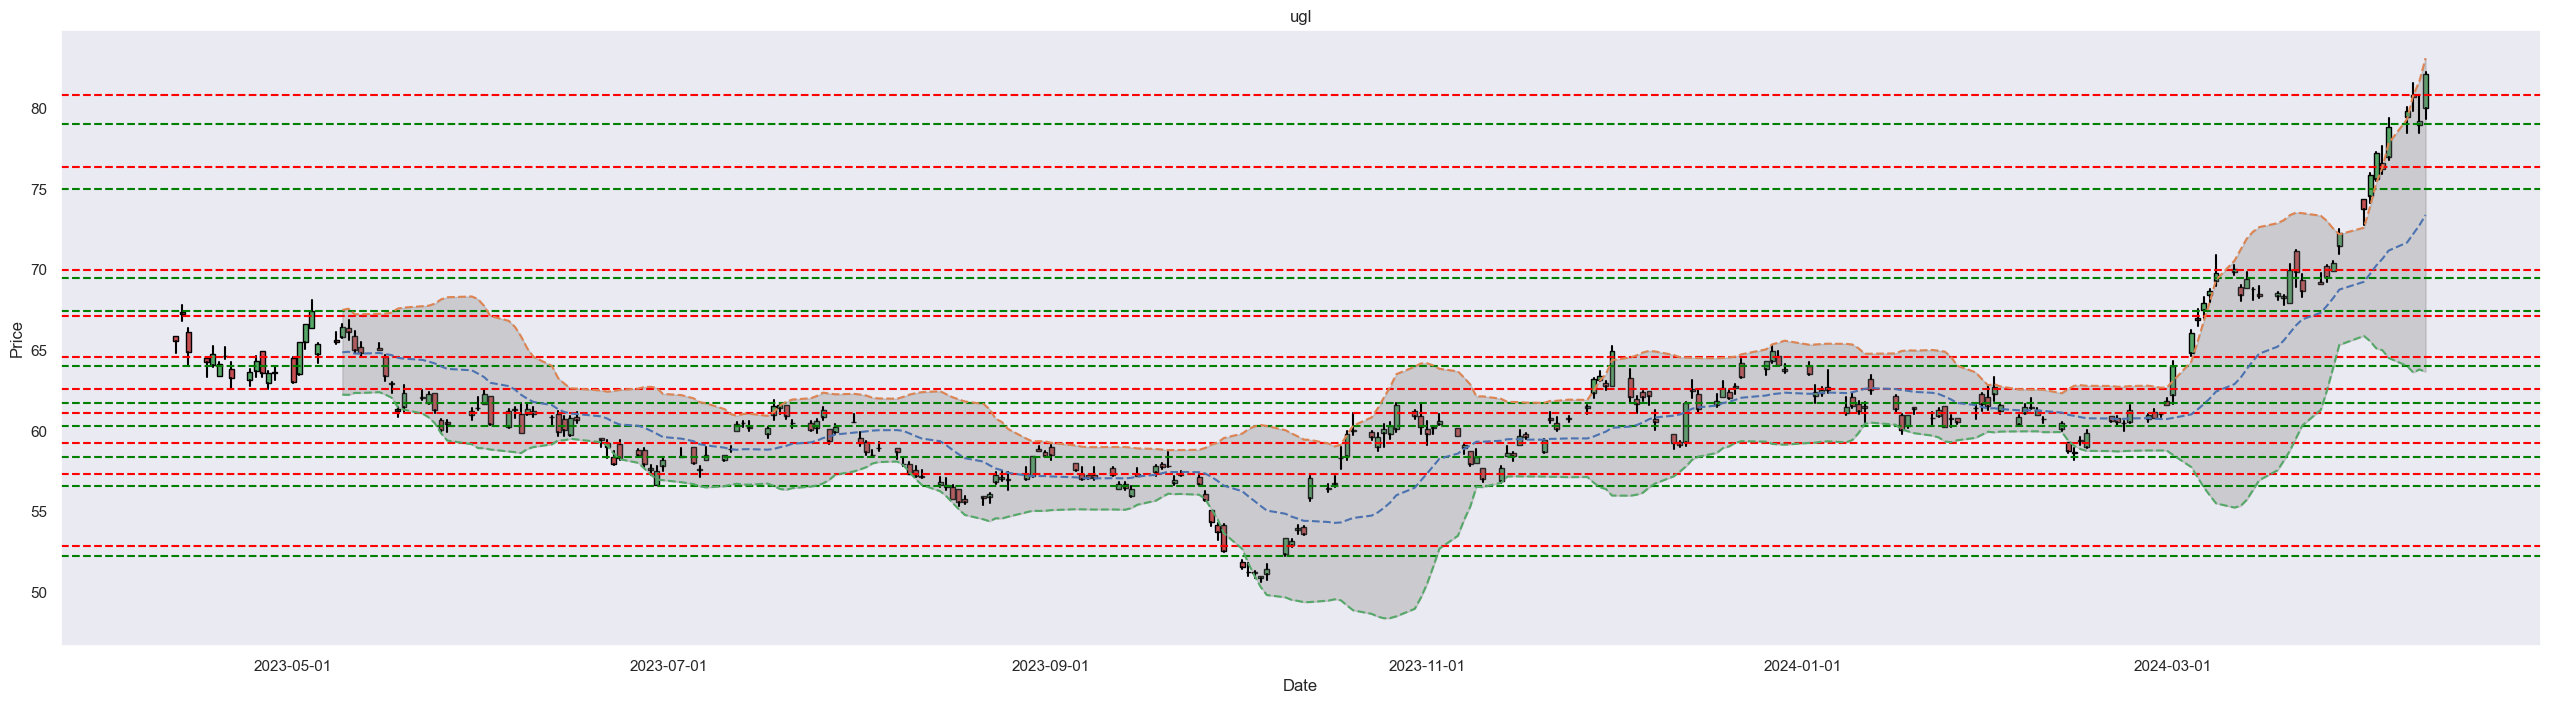

In [13]:
test_option_trading('ugl')

Random stocks

[*********************100%%**********************]  1 of 1 completed
2024-04-12
* previous stock price closing 174.6 ~ up 177.41 , down 170.29
Latest 20 Day MA: 171.94400177001953
Latest Lower Bollinger Band: 162.49926568645708
Latest Higher Bollinger Band: 181.38873785358197
[[160.015262  ]
 [170.29571261]
 [181.84925955]
 [194.85299911]
 [211.90535682]
 [230.9176651 ]
 [241.17151434]
 [252.05153832]
 [264.57850189]
 [279.34624863]]
[[166.78571356]
 [177.40576935]
 [188.79769193]
 [202.65350266]
 [219.70481477]
 [239.60459488]
 [251.90965587]
 [262.49142819]
 [277.66949921]
 [295.5933431 ]]


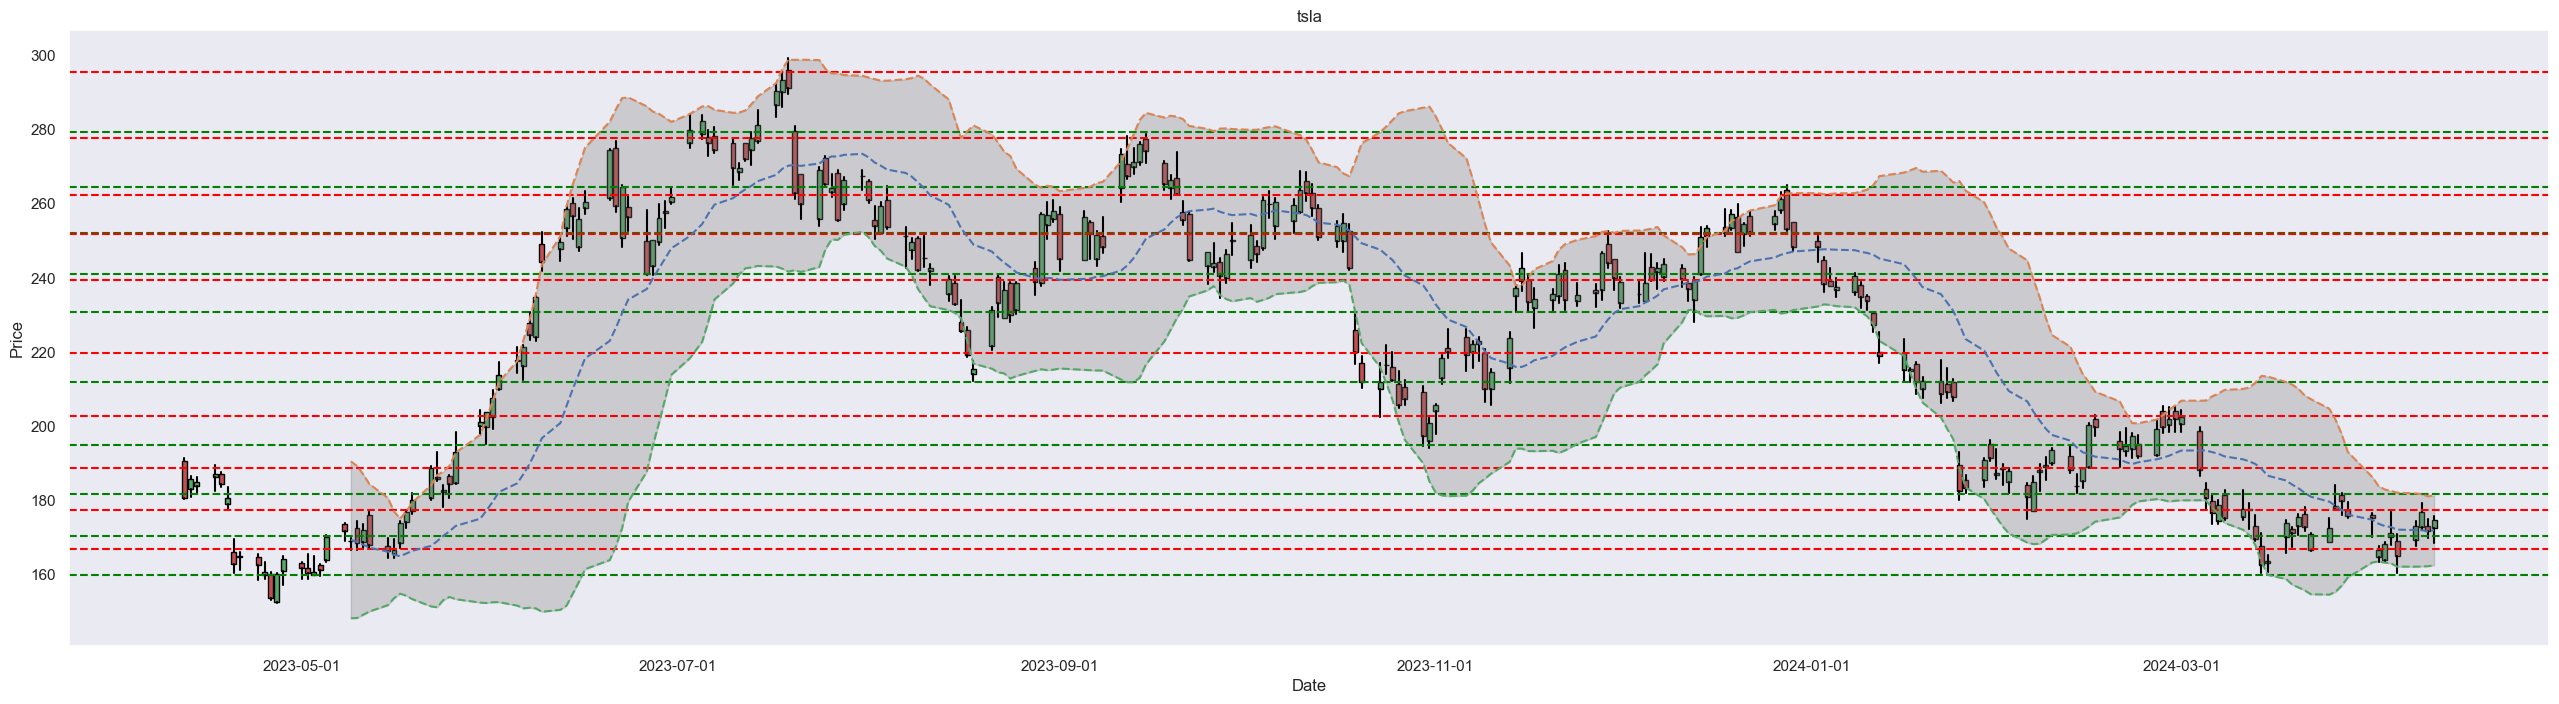

In [14]:
test_option_trading('tsla')

[*********************100%%**********************]  1 of 1 completed
2024-04-12
Break all resistance; record max stock price
* previous stock price closing 70060.61 ~ up 73750.08 , down 66632.66
Latest 20 Day MA: 68973.4525390625
Latest Lower Bollinger Band: 65030.453124406034
Latest Higher Bollinger Band: 72916.45195371898
[[17673.10230978]
 [21572.59903805]
 [26473.960493  ]
 [29873.5537233 ]
 [35813.17790948]
 [41480.38288309]
 [46690.71847345]
 [53312.88734375]
 [59377.38204309]
 [66632.66699219]]
[[17950.2877299 ]
 [22026.2038271 ]
 [27071.88352865]
 [30660.82719029]
 [37322.30722128]
 [42904.70986153]
 [49339.75806008]
 [57899.77996505]
 [62933.24549932]
 [69857.25835756]]


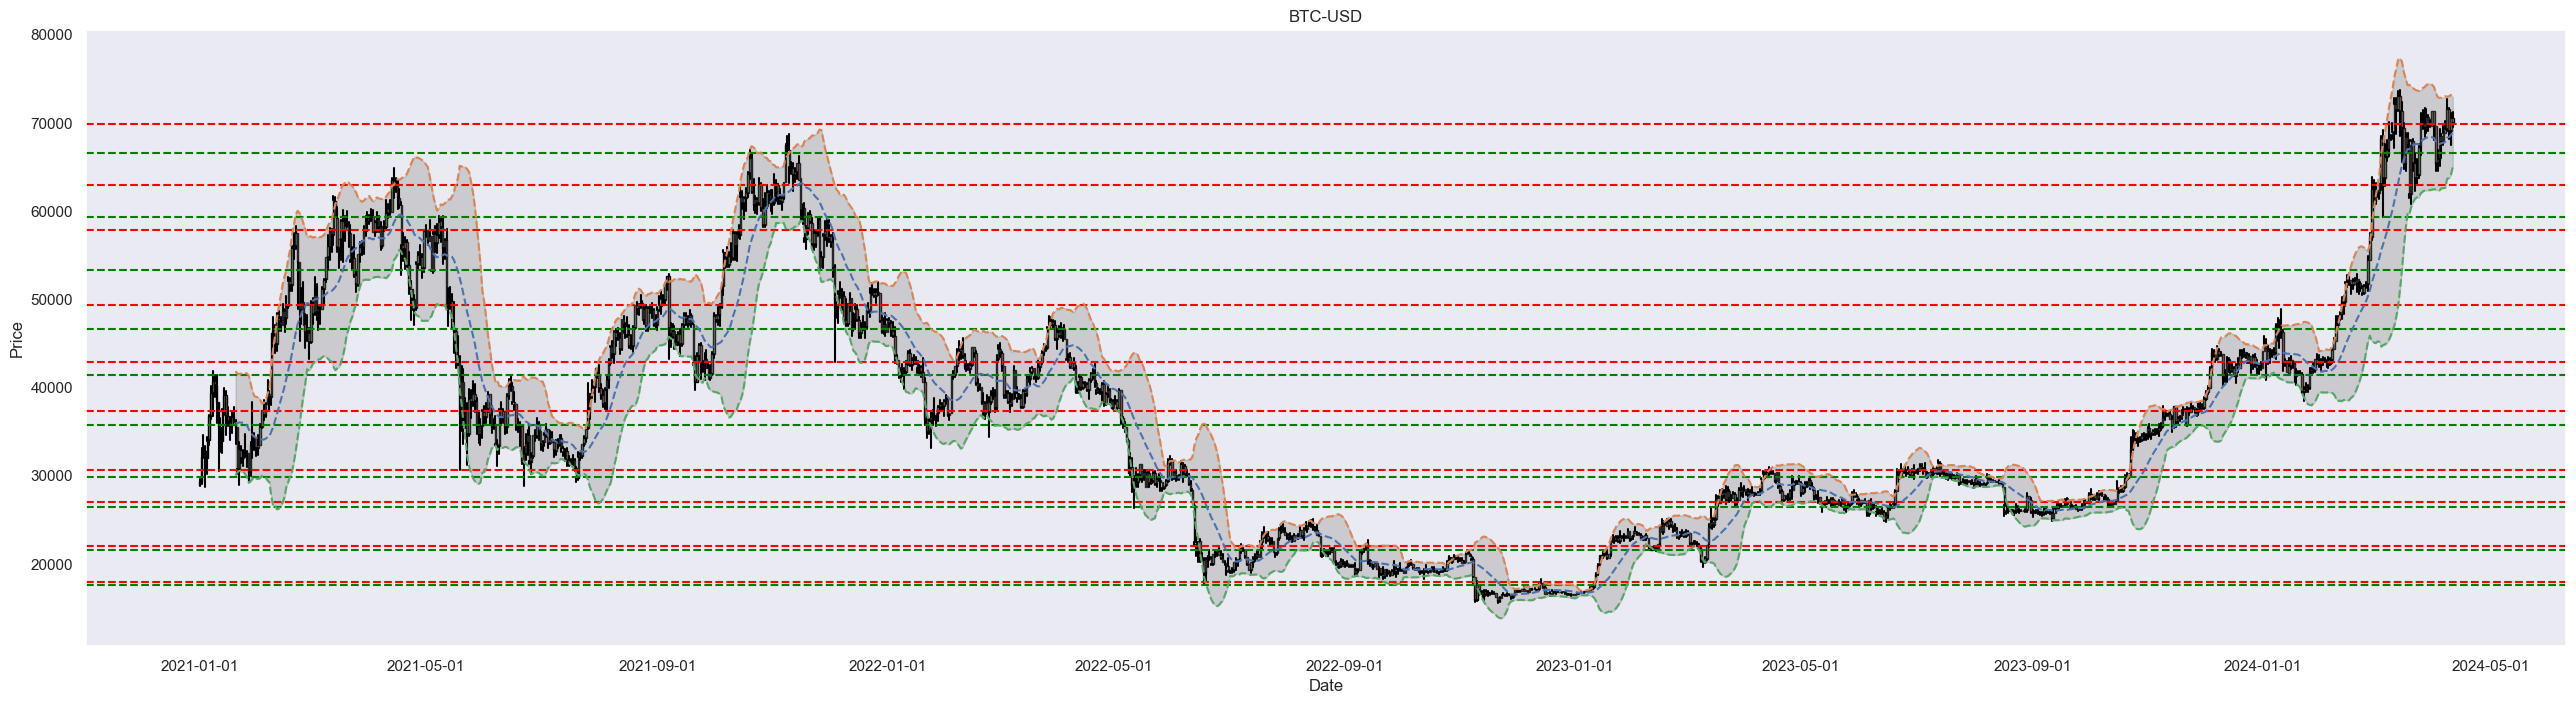

In [15]:
test_option_trading('BTC-USD', start='2021-01-01')